In [1]:
import numpy as np
import random
import cv2
import os

from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.optimizers import *

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
import tensorflow as tf

### 讀取頻譜圖路徑

In [2]:
INPUT_SELECT = 0 #決定模型的輸入 0: log mel scale spectrogram, 1: mfcc
IMG_SOURCE=0 #0: original, 2: augementation, 4: frame len 40ms 6: in class(沒有mfcc)
MODEL_DIR = ("Model/ms_model", "Model/mfcc_model")
MODEL_NAME = ("MS", "MFCC", "MS_AUG", "MFCC_AUG", "MS_40", "MFCC_40", "MS_inclass")
IMG_PATH = ("ImageData/original/spectrogram", "ImageData/original/mfcc",
                        "ImageData/augmentation/spectrogram", "ImageData/augmentation/mfcc",
                        "ImageData/frameLen_40ms/spectrogram","ImageData/frameLen_40ms/mfcc",
                        "ImageData/inclass")

In [3]:
root_path = IMG_PATH[INPUT_SELECT+IMG_SOURCE]
model_save_dir = MODEL_DIR[INPUT_SELECT]
model_name = MODEL_NAME[INPUT_SELECT+IMG_SOURCE]
folder_names = os.listdir(root_path)
print(folder_names)

['Blue', 'Classical', 'Country', 'Disco', 'EDM', 'Hiphop', 'Jazz', 'Metal', 'Pop', 'Reggae']


In [4]:
folders=[] #儲存各類別資料夾中的檔案名稱
for folder in folder_names:
    file_names=[]
    for file_name in os.listdir(root_path+"/"+folder):
        file_names.append(root_path+"/"+folder+"/"+file_name)
    folders.append(file_names)

class_count_list = [len(files) for files in folders] #紀錄每個類別各有多少檔案(後面會用到)
print("class count: ", len(folders))
print("class file count: ", class_count_list)

class count:  10
class file count:  [20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


### 讀取頻譜圖

In [5]:
Data = []
for folder in folders:
    for name in folder:
        spect = cv2.imread(name) #shape=(220, 449, 3)
        spect = cv2.resize(spect, (224, 224))
        #spect = np.moveaxis(spect, 2, 0)
        Data.append(spect)
Data = np.array(Data)

In [6]:
Data.shape

(200, 224, 224, 3)

### 製作Label

In [7]:
Label = []
for l, class_count in enumerate(class_count_list):
    for _ in range(class_count):
        Label.append(np.ones(1)*l)
Label = np.array(Label)

### 資料切割

In [8]:
seed =  random.randint(0, 1000**2)
X_train, X_test, y_train, y_test = train_test_split(Data, Label, test_size=0.3,
                                                    random_state=seed, stratify = Label)

In [9]:
seed =  random.randint(0, 1000**2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                                    random_state=seed, stratify = y_train)

In [10]:
y_train_onehot = np_utils.to_categorical(y_train)
y_val_onehot = np_utils.to_categorical(y_val)
y_test_onehot = np_utils.to_categorical(y_test)

In [11]:
print(X_train.shape, X_val.shape,  X_test.shape)
print(y_train.shape, y_val.shape,  y_test.shape)

(112, 224, 224, 3) (28, 224, 224, 3) (60, 224, 224, 3)
(112, 1) (28, 1) (60, 1)


### 模型建立

In [12]:
def VGG16(inputs):
    x = Conv2D(64, (3,3), activation='relu', padding = 'same')(inputs)
    x = Dropout(0.03)(x)
    x = Conv2D(64, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = Conv2D(128, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(256, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = Conv2D(256, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = Conv2D(256, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(512, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = Conv2D(512, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = Conv2D(512, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(512, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = Conv2D(512, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = Conv2D(512, (3,3), activation='relu', padding = 'same')(x)
    x = Dropout(0.03)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    return x

In [13]:
def LeNet(inputs):
    x = Conv2D(32, (5,5), activation='relu', padding = 'same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(64, (5,5), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    return x

In [14]:
def AlexNet(inputs):
    x = Conv2D(96, (11,11), strides=(4,4), activation='relu', padding = 'same')(inputs)
    x = MaxPooling2D(pool_size=(3,3), strides=(3,3))(x)
    x = Conv2D(256, (5,5), strides=(1,1), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
    x = Conv2D(384, (3,3), strides=(1,1), activation='relu', padding = 'same')(x)
    x = Conv2D(384, (3,3), strides=(1,1), activation='relu', padding = 'same')(x)
    x = Conv2D(256, (3,3), strides=(1,1), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1000, activation='relu')(x)
    return x

In [15]:
def Conv2d_BN(x, nb_filter,kernel_size, strides=(1,1), padding='same',name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
 
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)
    x = BatchNormalization(axis=3,name=bn_name)(x)
    return x
 
def Conv_Block(inpt,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt,nb_filter=nb_filter,kernel_size=kernel_size,strides=strides,padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size,padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt,nb_filter=nb_filter,strides=strides,kernel_size=kernel_size)
        x = add([x,shortcut])
        return x
    else:
        x = add([x,inpt])
        return x

def Resnet_34(inpt):
    x = ZeroPadding2D((3,3))(inpt)
    x = Conv2d_BN(x,nb_filter=64,kernel_size=(7,7),strides=(2,2),padding='valid')
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    #(56,56,64)
    x = Conv_Block(x,nb_filter=64,kernel_size=(3,3))
    x = Conv_Block(x,nb_filter=64,kernel_size=(3,3))
    x = Conv_Block(x,nb_filter=64,kernel_size=(3,3))
    #(28,28,128)
    x = Conv_Block(x,nb_filter=128,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
    x = Conv_Block(x,nb_filter=128,kernel_size=(3,3))
    x = Conv_Block(x,nb_filter=128,kernel_size=(3,3))
    x = Conv_Block(x,nb_filter=128,kernel_size=(3,3))
    #(14,14,256)
    x = Conv_Block(x,nb_filter=256,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
    x = Conv_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Conv_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Conv_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Conv_Block(x,nb_filter=256,kernel_size=(3,3))
    x = Conv_Block(x,nb_filter=256,kernel_size=(3,3))
    #(7,7,512)
    x = Conv_Block(x,nb_filter=512,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)
    x = Conv_Block(x,nb_filter=512,kernel_size=(3,3))
    x = Conv_Block(x,nb_filter=512,kernel_size=(3,3))
    x = AveragePooling2D(pool_size=(7,7))(x)
    x = Flatten()(x)
    return x

In [16]:
def CONV(inputs):
    x = Conv2D(64, (7,3), activation='relu', padding = 'same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(256, (3,3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(512, (3,3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    return x

In [17]:
input_shape = X_train[0].shape
output_dim = len(folders)

inputs = Input(shape=input_shape)
x = CONV(inputs)
outputs = Dense(output_dim, activation='softmax')(x)

model=Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      4096      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 256)       0     

In [18]:
opt = adam_v2.Adam(learning_rate=0.0001)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

# CREATE CALLBACKS
#"{epoch:03d}-val_acc{val_accuracy:.2f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_dir+"/"+model_name+".h5",
                                monitor='val_accuracy', 
                                save_best_only=True)
callbacks_list = [checkpoint]

In [19]:
history = model.fit(x=X_train, y=y_train_onehot,
                    validation_data=(X_val, y_val_onehot),
                    epochs=20, batch_size=8,
                    callbacks=callbacks_list,
                    verbose=1) # 訓練紀錄顯示

Epoch 1/20
14/14 [==============================] - 4s 62ms/step - loss: 44.5984 - accuracy: 0.0982 - val_loss: 3.2879 - val_accuracy: 0.1786
Epoch 2/20
14/14 [==============================] - 0s 33ms/step - loss: 2.5002 - accuracy: 0.1518 - val_loss: 2.2343 - val_accuracy: 0.1429
Epoch 3/20
14/14 [==============================] - 0s 32ms/step - loss: 2.1321 - accuracy: 0.2500 - val_loss: 2.1466 - val_accuracy: 0.2143
Epoch 4/20
14/14 [==============================] - 0s 32ms/step - loss: 1.8631 - accuracy: 0.3839 - val_loss: 2.0040 - val_accuracy: 0.4286
Epoch 5/20
14/14 [==============================] - 0s 32ms/step - loss: 1.5483 - accuracy: 0.5179 - val_loss: 1.9249 - val_accuracy: 0.3571
Epoch 6/20
14/14 [==============================] - 0s 32ms/step - loss: 1.2571 - accuracy: 0.6250 - val_loss: 1.7928 - val_accuracy: 0.3929
Epoch 7/20
14/14 [==============================] - 0s 32ms/step - loss: 0.9204 - accuracy: 0.7321 - val_loss: 1.6494 - val_accuracy: 0.5357
Epoch 8/20
1

In [20]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

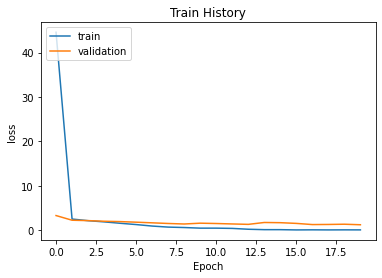

In [21]:
# 1. 圖表顯示 loss
model.load_weights(model_save_dir+"/"+model_name+".h5")
show_train_history(history, 'loss', 'val_loss')

In [22]:
scores = model.evaluate(X_test, y_test_onehot, batch_size=8, verbose=0)
print("Accuracy of testing data = {:2.2f}%".format(scores[1]*100.0))

Accuracy of testing data = 73.33%


In [23]:
# import pickle
# def save_history(history, fn):
#     with open(fn, 'wb') as fw:
#         pickle.dump(history.history, fw, protocol=2)
# save_history(history,model_save_path+"_history.bin")